In [1]:
import numpy as np
from typing import Callable, Optional, Union, Tuple, Dict, Any

Number = Union[int, float]


class GBM:
    """
    Geometric Brownian Motion (GBM) simulator on [0, 1].

    SDE: dS_t = mu(t, S_t) * S_t dt + sigma(t, S_t) * S_t dW_t

    If mu_func / sigma_func are provided (callables), they are used.
    Otherwise constants mu / sigma are used.

    Discretization:
      - Brownian motion via increments dW ~ N(0, dt)
      - GBM update using "log-Euler" (exact for constant mu/sigma and good for time/state varying):
            S_{k+1} = S_k * exp((mu_k - 0.5*sigma_k^2)*dt + sigma_k*dW_k)
    """

    def __init__(
        self,
        delta_t: Number = 0,
        delta_x: Number = 0,  # kept for compatibility; not used for GBM
        N_steps: int = 0,
        mu: Number = 0.0,
        sigma: Number = 0.0,
        mu_func: Optional[Callable[..., Number]] = None,
        sigma_func: Optional[Callable[..., Number]] = None,
        s0: Number = 1.0,
    ):
        self.delta_x = delta_x  # not used, but stored
        self.mu = float(mu)
        self.sigma = float(sigma)
        self.mu_func = mu_func if callable(mu_func) else None
        self.sigma_func = sigma_func if callable(sigma_func) else None
        self.s0 = float(s0)

        # Determine dt and number of steps for interval [0, 1]
        if delta_t and delta_t > 0:
            self.delta_t = float(delta_t)
            self.N_steps = int(round(1.0 / self.delta_t))
            # Recompute dt to fit exactly into [0,1]
            self.delta_t = 1.0 / self.N_steps
        elif N_steps and N_steps > 0:
            self.N_steps = int(N_steps)
            self.delta_t = 1.0 / self.N_steps
        else:
            raise ValueError("Provide either delta_t > 0 or N_steps > 0.")

        if self.s0 <= 0:
            raise ValueError("s0 must be > 0 for GBM.")
        if self.sigma < 0:
            raise ValueError("sigma must be >= 0.")

    def _eval_coef(self, f: Optional[Callable[..., Number]], const: float, t: float, s: float) -> float:
        """Evaluate coefficient either from callable or constant."""
        if f is None:
            return const

        # Try common signatures: f(t), f(t,s), f(s,t)
        try:
            return float(f(t, s))
        except TypeError:
            try:
                return float(f(s, t))
            except TypeError:
                return float(f(t))

    def build_path(
        self,
        seed: Optional[int] = None,
        return_times: bool = True,
        return_brownian: bool = False,
    ) -> Union[np.ndarray, Tuple[np.ndarray, ...]]:
        """
        Build a GBM path on [0,1].

        Returns:
          - by default: (t, S) where both are numpy arrays of length N_steps+1
          - if return_times=False: S
          - if return_brownian=True: also returns W (Brownian path)
        """
        rng = np.random.default_rng(seed)

        dt = self.delta_t
        n = self.N_steps

        # Time grid
        t = np.linspace(0.0, 1.0, n + 1)

        # Brownian increments and path
        dW = np.sqrt(dt) * rng.standard_normal(n)
        W = np.empty(n + 1, dtype=float)
        W[0] = 0.0
        W[1:] = np.cumsum(dW)

        # GBM path
        S = np.empty(n + 1, dtype=float)
        S[0] = self.s0

        for k in range(n):
            tk = t[k]
            Sk = S[k]
            mu_k = self._eval_coef(self.mu_func, self.mu, tk, Sk)
            sig_k = self._eval_coef(self.sigma_func, self.sigma, tk, Sk)
            if sig_k < 0:
                raise ValueError(f"sigma_func returned a negative value at step {k}: {sig_k}")

            # log-Euler / exact step if coefficients are constant on the step
            S[k + 1] = Sk * np.exp((mu_k - 0.5 * sig_k**2) * dt + sig_k * dW[k])

        # Output packing
        out = []
        if return_times:
            out.append(t)
        out.append(S)
        if return_brownian:
            out.append(W)

        return out[0] if len(out) == 1 else tuple(out)


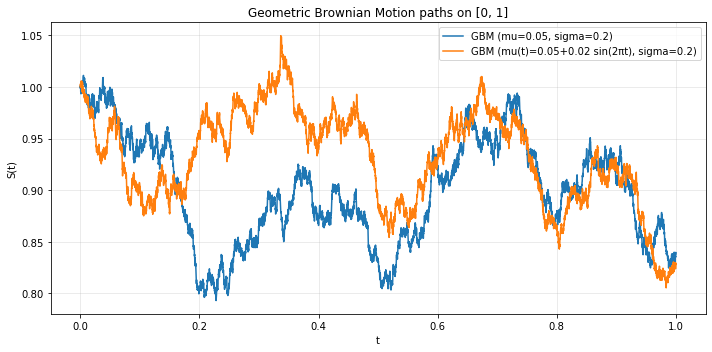

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# --- Simulations ---
gbm = GBM(N_steps=10000, mu=0.05, sigma=0.2, s0=1.0)
t, S = gbm.build_path(seed=42)

gbm2 = GBM(
    N_steps=10000,
    mu_func=lambda t: 0.05 + 0.02*np.sin(2*np.pi*t),
    sigma_func=lambda t: 0.2,
    s0=1.0
)
t2, S2 = gbm2.build_path(seed=1)

# --- Plot ---
plt.figure(figsize=(10, 5))
plt.plot(t, S, label="GBM (mu=0.05, sigma=0.2)")
plt.plot(t2, S2, label="GBM (mu(t)=0.05+0.02 sin(2πt), sigma=0.2)")
plt.xlabel("t")
plt.ylabel("S(t)")
plt.title("Geometric Brownian Motion paths on [0, 1]")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
